In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [9]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [10]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
stats = calc_temps('2012-08-01', '2012-08-07')
temp_stats = list(np.ravel(stats))

tmin = temp_stats[0]
tavg = temp_stats[1]
tmax = temp_stats[2]

print(tmin, tavg, tmax)


67.0 74.97826086956522 82.0


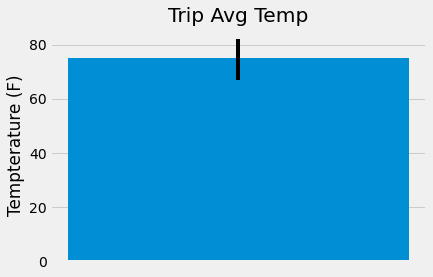

In [11]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
data = [tavg]
x_axis = len(data)
errmax = (tmax-tavg)
errmin = (tavg-tmin)
error = ([[errmin],[errmax]])
plt.bar(x = x_axis, height = data, yerr = error, align = 'center')
plt.title('Trip Avg Temp')
plt.xticks(ticks=[])
plt.ylabel('Tempterature (F)')
plt.show()

### Daily Rainfall Average

In [36]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel = [func.sum(Measurement.prcp), Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation]
rainfall = session.query(*sel).\
    filter(Measurement.station == Station.station).\
    filter(func.strftime("%Y-%m-%d", Measurement.date) >= '2012-08-01').\
    filter(func.strftime("%Y-%m-%d", Measurement.date) <= '2012-08-07').\
    group_by(Measurement.station).\
    order_by(func.avg(Measurement.prcp).desc()).all()

print('From August 1 to August 7, 2012:')

for record in rainfall:
    (rain, station, name, latitude, longitude, elevataion) = record
    print(f'{rain} inches of rain fell at the {name} station number {station}, located at the coordinates: {latitude}, {longitude} and an elevation of {elevataion}m')

From August 1 to August 7, 2012:
1.16 inches of rain fell at the MANOA LYON ARBO 785.2, HI US station number USC00516128, located at the coordinates: 21.3331, -157.8025 and an elevation of 152.4m
0.26 inches of rain fell at the UPPER WAHIAWA 874.3, HI US station number USC00518838, located at the coordinates: 21.4992, -158.0111 and an elevation of 306.6m
0.24 inches of rain fell at the WAIHEE 837.5, HI US station number USC00519281, located at the coordinates: 21.45167, -157.84888999999998 and an elevation of 32.9m
0.22 inches of rain fell at the KANEOHE 838.1, HI US station number USC00513117, located at the coordinates: 21.4234, -157.8015 and an elevation of 14.6m
0.07 inches of rain fell at the WAIMANALO EXPERIMENTAL FARM, HI US station number USC00519523, located at the coordinates: 21.33556, -157.71139 and an elevation of 19.5m
0.01 inches of rain fell at the HONOLULU OBSERVATORY 702.2, HI US station number USC00511918, located at the coordinates: 21.3152, -157.9992 and an elevati

In [13]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [14]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2012-08-01'
end_date = '2012-08-07'

# Use the start and end date to create a range of dates
trip_dates = pd.date_range(start_date, end_date)

# Strip off the year and save a list of strings in the format %m-%d
dates = [d.strftime('%m-%d') for d in trip_dates]

# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.
normals = [daily_normals(d) for d in dates]
normals


[[(67.0, 75.54, 83.0)],
 [(68.0, 75.60377358490567, 84.0)],
 [(70.0, 76.61111111111111, 85.0)],
 [(69.0, 76.71153846153847, 84.0)],
 [(69.0, 76.14814814814815, 82.0)],
 [(67.0, 76.25, 83.0)],
 [(71.0, 77.15686274509804, 83.0)]]

In [15]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip = [list(np.ravel(n)) for n in normals]

trip_df = pd.DataFrame(trip, columns=['Min', 'Avg', 'Max']).set_index([dates])
trip_df

,Min,Avg,Max
08-01,67.0,75.540000,83.0
08-02,68.0,75.603774,84.0
08-03,70.0,76.611111,85.0
08-04,69.0,76.711538,84.0
08-05,69.0,76.148148,82.0
08-06,67.0,76.250000,83.0
08-07,71.0,77.156863,83.0


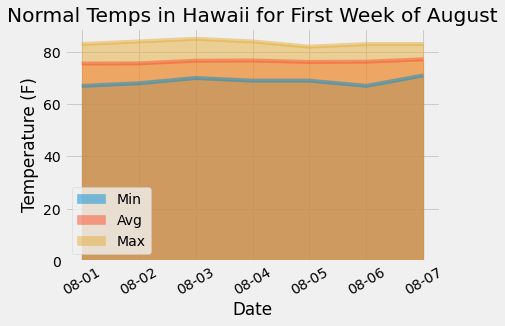

In [18]:
# Plot the daily normals as an area plot with `stacked=False`
trip_df.plot(kind='area', stacked= False, title = 'Normal Temps in Hawaii for First Week of August', rot=30)
plt.xlabel('Date')
plt.ylabel('Temperature (F)')
plt.show()

## Close Session

In [17]:
session.close()